# Implementation
Author: Jørgen S. Dokken

In this section, we will solve the deflection of the membrane problem.
After finishing this section, you should be able to:
- Create a simple mesh using the GMSH Python API and load it into DOLFINx
- How to create a constant boundary conditions using a geometrical identifier
- Using s`ufl.SpatialCoordinate` to create a spatially varying function
- How to interpolate a `ufl.Expression` into an appropriate function space
- How to evaluate a `dolfinx.Function` at any point $x$
- Use Paraview to visualize the solution of a PDE

## Creating the mesh

To create the computational geometry, we use the python-API of [GMSH](http://gmsh.info/). We start by import the gmsh-module, and initalizing it.

In [1]:
import gmsh
gmsh.initialize()

The next step is to create the membrane and starting the computations by the GMSH CAD kernel, to generate the relevant underlying data structures. The arguments into `addDisk` is the x, y and z coordinate of the center of the circle, while the to last argument is the x-radius and y-radius.

In [2]:
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()

The next step is to make the membrane a physical surface, such that it is recognized by gmsh when generating the mesh. As a surface is a two-dimensional entity, we add two as the first argument, the entity tag of the membrane as the second argument, and the last argument is the physical tag. In a later demo, we will get into when this tag matters.

In [3]:
gdim = 2
status = gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

Finally, we generate the two-dimensional mesh. We set a uniform mesh size by modifying the GMSH options

In [4]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000206132s, CPU 0.000536s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0743901s, CPU 0.074966s)
Info    : 1549 nodes 3097 elements


We will import the GMSH-mesh directly from GMSH, using the approach in Section 2 of [A GMSH tutorial for DOLFINx](http://jsdokken.com/converted_files/tutorial_gmsh.html). To make sure this runs in parallel and  serial, we will read in the mesh on one processor, and let DOLFINx distribute the mesh data among the processros.

In [5]:
from dolfinx.io import extract_gmsh_geometry, extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh
from mpi4py import MPI
if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    geometry_data = extract_gmsh_geometry(gmsh.model)
    # Get mesh topology for each element
    topology_data = extract_gmsh_topology_and_markers(gmsh.model)

The topology data is a dictionary, where the key is the gmsh cell type (an integer). Each key accesses a dictionary with the topology data and corresponding topology markers. As this mesh only contains one cell type (triangles), as we did not mark any facets, we do not need to loop over the keys of this dictionary, only extract the first one.

In [6]:
import numpy as np
if MPI.COMM_WORLD.rank == 0:
    # Extract the cell type and number of nodes per cell and broadcast
    # it to the other processors 
    gmsh_cell_type = list(topology_data.keys())[0]    
    properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
    name, dim, order, num_nodes, local_coords, _ = properties
    cells = topology_data[gmsh_cell_type]["topology"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([gmsh_cell_type, num_nodes], root=0)
else:        
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

As we have now broadcasted all the information required to distribute the mesh in parallel

In [7]:
from dolfinx.io import cell_perm_gmsh
from dolfinx.cpp.mesh import to_type
from dolfinx.mesh import create_mesh

# Permute topology data from MSH-ordering to dolfinx-ordering
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = cell_perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]

# Create distributed mesh
mesh = create_mesh(MPI.COMM_WORLD, cells, geometry_data[:, :gdim], ufl_domain)

We define the function space as in the previous tutorial

In [8]:
from dolfinx import fem
V = fem.FunctionSpace(mesh, ("CG", 1))

## Defining a spatially varying load
The right hand side pressure function is represented using `ufl.SpatialCoordinate` and a two constants, one for $\beta$ and one for $R_0$.

In [9]:
import ufl
from petsc4py.PETSc import ScalarType
x = ufl.SpatialCoordinate(mesh)
beta = fem.Constant(mesh, ScalarType(12))
R0 = fem.Constant(mesh, ScalarType(0.3))
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))

## Create a Dirichlet boundary condition using geometrical conditions
The next step is to create the homogenous boundary condition. As opposed to the [First tutorial](./fundamentals_code.ipynb) we will use `dolfinx.fem.locate_dofs_geometrical` to locate the degrees of freedom on the boundary. As we know that our domain is a circle with radius 1, we know that any degree of freedom should be located at a coordinate $(x,y)$ such that $\sqrt{x^2+y^2}=1$.

In [10]:
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)
boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

As our Dirichlet condition is homogenous (`u=0` on the whole boundary), we can initialize the `dolfinx.fem.dirichletbc` with a constant value, the degrees of freedom and the function space to apply the boundary condition on.

In [11]:
bc = fem.dirichletbc(ScalarType(0), boundary_dofs, V)

## Defining the variational problem
The variational problem is the same as in our first Poisson problem, where `f` is replaced by `p`.

In [12]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = p * v * ufl.dx
problem = fem.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Interpolation of a `ufl`-expression
As we previously defined the load `p` as a spatially varying function, we would like to interpolate this function into an appropriate function space for visualization. To do this we use the `dolfinx.Expression`. The expression takes in any `ufl`-expression, and a set of points on the reference element. We will use the interpolation points of the space we want to interpolate in to.

In [13]:
expr = fem.Expression(p, V.element.interpolation_points)
pressure = fem.Function(V)
pressure.interpolate(expr)

## Plotting the solution over a line
We first plot the deflection $u_h$ over the domain $\Omega$.

In [39]:
from dolfinx.plot import create_vtk_topology
import pyvista
pyvista.set_jupyter_backend("ipygany")

# Extract topology from mesh and create pyvista mesh
topology, cell_types = create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)


# Set deflection values and add it to plotter
grid.point_data["u"] = uh.compute_point_values().real
warped = grid.warp_by_scalar("u", factor=25)

plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    plotter.screenshot("deflection.png")

AppLayout(children=(VBox(children=(HTML(value='<h3>u</h3>'), Dropdown(description='Colormap:', options={'BrBG'…

We next plot the load on the domain

In [40]:
load_plotter = pyvista.Plotter()
grid.point_data["p"] = pressure.compute_point_values().real
warped_p = grid.warp_by_scalar("p", factor=0.5)
warped_p.set_active_scalars("p")
load_plotter.add_mesh(warped_p, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    load_plotter.show()
else:
    pyvista.start_xvfb()
    load_plotter.screenshot("load.png")

AppLayout(children=(VBox(children=(HTML(value='<h3>p</h3>'), Dropdown(description='Colormap:', options={'BrBG'…

## Making curve plots throughout the domain
Another way to compare the deflection and the load is to make a plot along the line $x=0$. 
This is just a matter of defining a set of points along the $y$-axis and evaluating the finite element functions $u$ and $p$ at these points. 

In [41]:
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []
p_values = []

As a finite element function is the linear combination of all degrees of freedom, $u_h(x)=\sum_{i=1}^N c_i \phi_i(x)$ where $c_i$ are the coefficients of $u_h$, $\phi_i$ the $i$th basis function, we can compute the exact solution at any point in $\Omega$.
However, as a mesh consists of a large set of degrees of freedom (i.e. $N$ is large), we want to reduce the number of evaluations of the basis function $\phi_i(x)$. We do this by identifying which cell of the mesh $x$ is in. 
This is efficiently done by creating a bounding box tree of the cells of the mesh, allowing a quick recursive search through the mesh entities.

In [42]:
from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(mesh, mesh.topology.dim)

Now we can compute which cells the bounding box tree collides with using `dolfinx.geometry.compute_collisions_point`. This function returns a list of cells whose bounding box collide for each input point. As different points might have different number of cells, the data is stored in `dolfinx.cpp.graph.AdjacencyList_int32`, where one can access the cells for the `i`th point by calling `links(i)`.
 However, as the bounding box of a cell spans more of $\mathbb{R}^n$ than the actual cell, we check that the actual cell collides with cell 
 using `dolfinx.geometry.select_colliding_cells`, who measures the exact distance between the point and the cell (approximated as a convex hull for higher order geometries).
This function also returns an adjacency-list, as the point might align with a facet, edge or vertex that is shared between multiple cells in the mesh.

Finally, we would like the code below to run in parallel, when the mesh is distributed over multiple processors. In that case, it is not guaranteed that every point in `points` is on each processor. Therefore we create a subset `points_on_proc` only containing the points found on the current processor.

In [43]:
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

We now got a list of points on the processor, on in which cell each point belongs. We can then call `uh.eval` and `pressure.eval` to obtain the set of values for all the points.

In [44]:
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = pressure.eval(points_on_proc, cells)

As we now have an array of coordinates and two arrays of function values, we use matplotlib to plot them

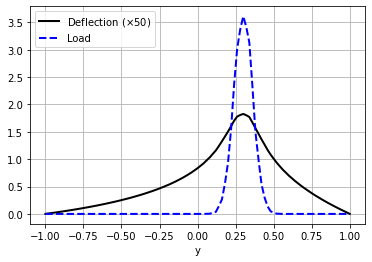

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(points_on_proc[:,1], 50*u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth = 2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

## Saving functions to file
As mentioned in the previous section, we can also use Paraview to visualize the solution.

In [46]:
from dolfinx.io import XDMFFile
pressure.name = "Load"
uh.name = "Deflection"
with XDMFFile(MPI.COMM_WORLD, "results_membrane.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(pressure)
    xdmf.write_function(uh)